In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

from models import RecurrentSpaceNet

from scipy import stats

In [2]:
# Simple test dataset maker; square box + bounce off walls

class DatasetMaker(object):
    def __init__(self, chamber_size = 1):
        self.chamber_size = chamber_size
        
    def bounce(self, r, v):
        outside = np.abs(r + v) >= self.chamber_size
        v[outside] = -v[outside] 
        return v

    def generate_dataset(self, samples, timesteps):
        stddev = 4*np.pi # von Mises
        r = np.zeros((samples, timesteps, 2))

        s = np.random.rayleigh(0.05, (samples, timesteps))
        prev_hd = np.random.uniform(0, 2*np.pi, samples)

        r[:,0] = np.random.uniform(-self.chamber_size, self.chamber_size, (samples, 2)) 

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, stddev, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v) 
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v # dt = 1

        v = np.diff(r, axis = 1)
        return torch.tensor(r.astype('float32')), torch.tensor(v.astype('float32'))


(-1.0, 1.0, -1.0, 1.0)

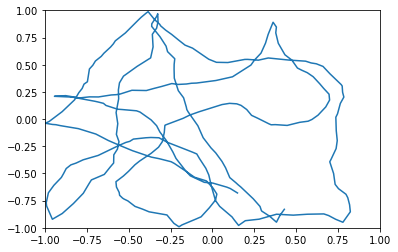

In [3]:
genny = DatasetMaker()
r, v = genny.generate_dataset(1, 300)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])

In [4]:
train_steps = 1000

n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations
timesteps = 500
bs = 32 # batch size

model = RecurrentSpaceNet(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps)
    r_label = r[:,1:]
    loss = model.train_step(x = v, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.062913: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]


Text(0, 0.5, 'Train Loss')

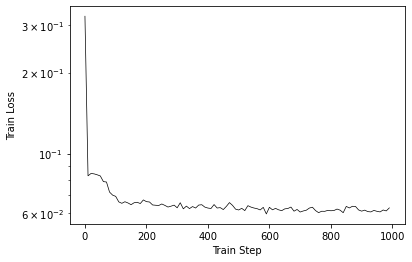

In [5]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [12]:
r, v = genny.generate_dataset(1, timesteps)
p, _ = model.spatial_representation(v)
p = p.detach().numpy()
p.shape

(1, 499, 100)

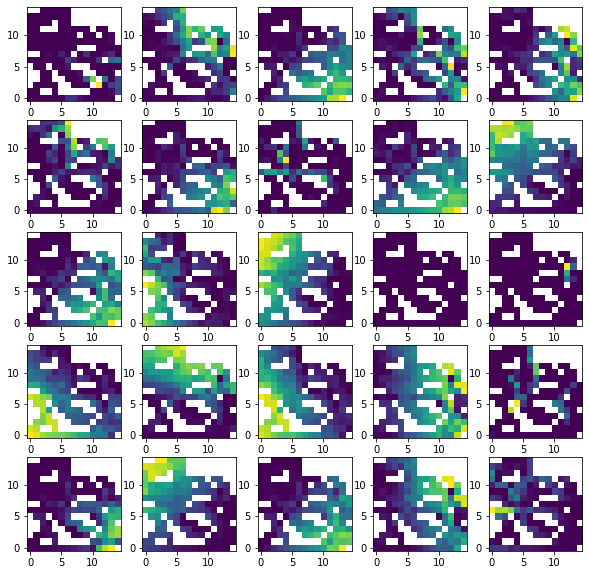

In [13]:
n_show = 5
bins = np.linspace(-1, 1, 16)

fig, ax = plt.subplots(n_show, n_show, figsize = (10,10)) 
r0 = r[:,1:].detach().numpy()

sample = 0
ps = p[sample]
rs = r0[sample]

for i in range(n_show**2):
    hist, _,_,_ = stats.binned_statistic_2d(values = ps[:, i],x = rs[:,0], y=rs[:,1], bins = bins)
    ax[i//n_show, i%n_show].imshow(hist.T, origin = "lower")